# Proyecto Final: Predicción de Oportunidades de Renovación Exitosas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Objetivo

- Identificar de manera precisa las oportunidades de renovación del cliente que alcanzan la etapa de **"Closed Won"**, permitiendo así comprender los factores y estrategias asociadas con el éxito en la retención de clientes.
- Desarrollar un modelo predictivo avanzado que, basado en diversas variables y patrones históricos, pueda anticipar con precisión si una oportunidad de renovación se convertirá en un éxito o no, brindando así a la empresa la capacidad de tomar medidas proactivas para retener clientes y maximizar la rentabilidad.

In [3]:
import sys

print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


## Set de Datos

El dataset contiene **122,648** registros con información sobre las oportunidades de renovación de los productos que hacen los clientes de Cisco.

Los campos son los siguientes:

**Deal Id**: ID de la oportunidad de renovación (puede incluir varios registros).

**Product**: Producto a renovar.

**GLOBAL_ULTIMATE_ID**: ID global del cliente.

**ATR**: Valor anual del registro a renovar.

**ATR Band**: Banda en la que se encuentra el valor anual del registro a renovar.

**Stage**: Etapa de la renovación.

**Risk Profile**: Nivel de riesgo de la renovación.

**Professional Services Flag**: Flag que indica si la Unidad de Negocio del Cliente tiene contratados Servicios Profesionales de Cisco.

**Premium Services Flag**: Flag que indica si la Unidad de Negocio del Cliente tiene contratado soporte premium con Cisco (Success Tracks).

**SAV Level 3**: Nivel 3 de la estructura comercial que atiende al cliente.

**INDUSTRY**: Industria en la que se encuentra el cliente.

**Lifecycle Stage**: Etapa de la adopción.

**CONTRACT START DATE**: Fecha de inicio del contrato.

**TERM END DATE**: Fecha de expiración del contrato.

**Duration (Months)**: duración del contrato en meses.

**Duration Band**: Banda en la que se encuentra la duración del contrato.

**WEIGHTED RISK PCT**: Riesgo ponderado del cliente.

**CX_MAX_LAST_TELEMETRY_30_FLG**: Flag de telemetría.

**Is Digital Enrolled**: Flag que inidica si el cliente se encuentra digitalmente enrolado.


### Instalación de librerías

In [4]:
!pip install lime
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4a6d250e1bdec5c9e9ec39784550c024924942375b575da57f2516e9a7097853
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## Cargar librerías

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime as datetime
from datetime import timedelta as timedelta
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import lime
import lime.lime_tabular

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Desplegar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Configurar opciones de visualización para que no se trunquen los números
pd.set_option('display.float_format', '{:.2f}'.format)

## Cargar los datos

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Hackathon CX 2024/oportunidades_renovacion.csv')

In [8]:
data.shape

(65476, 21)

In [9]:
data.columns

Index(['Deal Id', 'Product', 'GLOBAL_ULTIMATE_ID', 'ATR', 'ATR Band', 'Stage',
       'Risk Profile', 'Professional Services Flag', 'Premium Services Flag',
       'SAV Level 3', 'INDUSTRY', 'Lifecycle Stage', 'CONTRACT START DATE',
       'TERM END DATE', 'Duration (Months)', 'Duration Band',
       'WEIGHTED RISK PCT', 'CX_MAX_LAST_TELEMETRY_30_FLG',
       'Is Digital Enrolled', 'De-Risk Flag', 'CSE Flag'],
      dtype='object')

In [10]:
data.GLOBAL_ULTIMATE_ID.nunique()

5099

In [11]:
#Checar si hay valores nulos en los datos
data.isnull().sum()

Deal Id                          2050
Product                             0
GLOBAL_ULTIMATE_ID                  0
ATR                                 0
ATR Band                            0
Stage                               0
Risk Profile                        0
Professional Services Flag        128
Premium Services Flag               0
SAV Level 3                         0
INDUSTRY                            0
Lifecycle Stage                     0
CONTRACT START DATE              4136
TERM END DATE                       0
Duration (Months)                   0
Duration Band                       0
WEIGHTED RISK PCT                   0
CX_MAX_LAST_TELEMETRY_30_FLG    12586
Is Digital Enrolled                 0
De-Risk Flag                        0
CSE Flag                            0
dtype: int64

In [12]:
# Eliminar valores nulos en las columnas especificadas
data = data.dropna(subset=["Deal Id", "Professional Services Flag", "CONTRACT START DATE"])

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59577 entries, 5 to 65475
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Deal Id                       59577 non-null  float64
 1   Product                       59577 non-null  object 
 2   GLOBAL_ULTIMATE_ID            59577 non-null  int64  
 3   ATR                           59577 non-null  object 
 4   ATR Band                      59577 non-null  object 
 5   Stage                         59577 non-null  object 
 6   Risk Profile                  59577 non-null  object 
 7   Professional Services Flag    59577 non-null  object 
 8   Premium Services Flag         59577 non-null  object 
 9   SAV Level 3                   59577 non-null  object 
 10  INDUSTRY                      59577 non-null  object 
 11  Lifecycle Stage               59577 non-null  object 
 12  CONTRACT START DATE           59577 non-null  object 
 13  TERM E

In [14]:
print(len(data.columns)) # Should print 21

21


## Limpieza de los datos

In [15]:
# Convertir las columnas de fecha a datetime
data['Contract_Start_Date'] = pd.to_datetime(data['CONTRACT START DATE'], format='%d/%m/%Y')
data['Term_End_Date'] = pd.to_datetime(data['TERM END DATE'], format='%d/%m/%Y')

In [16]:
data.shape

(59577, 23)

In [17]:
# Eliminar registros donde la fecha de inicio de contrato es mayor que la fecha de término de contrato
data = data.drop(data[data['Contract_Start_Date'] > data['Term_End_Date']].index)

In [18]:
data.shape

(59392, 23)

In [19]:
# Remover todos los símbolos no deseados de las columnas y convertir a tipo float
data['ATR'] = data['ATR'].replace('[^\d.]', '', regex=True).astype(float)
data['Duration (Months)'] = data['Duration (Months)'].replace(' -   ', 0)
data['Duration (Months)'] = pd.to_numeric(data['Duration (Months)'])

In [20]:
data.shape

(59392, 23)

In [21]:
# Ordenar los datos primero por CX Customer BU Id, luego por Contract_Start_Date y finalmente por Term_End_Date
data = data.sort_values(by=['GLOBAL_ULTIMATE_ID', 'Contract_Start_Date'], ascending=[True, False])

In [22]:
data.head()

Deal Id Product  GLOBAL_ULTIMATE_ID     ATR          ATR Band  \
40835 69338673.00    NGFW                7000 2457.58  01_Less_than_25K   
13809 56018199.00    NGFW                7000 7169.93  01_Less_than_25K   
56368 69347194.00    NGFW                7000 7150.29  01_Less_than_25K   
8380  55824722.00    NGFW                7000 1738.16  01_Less_than_25K   
25524 44928877.00    NGFW                9000  562.78  01_Less_than_25K   

                 Stage Risk Profile Professional Services Flag  \
40835     1 - Prospect         High                          Y   
13809   6 - Closed Won          Low                          Y   
56368     1 - Prospect         High                          Y   
8380   6 - Closed Lost          Low                          Y   
25524     1 - Prospect          Low                          Y   

      Premium Services Flag SAV Level 3 INDUSTRY Lifecycle Stage  \
40835                     Y     MEXICO-  UNKNOWN        08_Renew   
13809                     Y     MEXICO-  UNKNOWN        08_Renew   
56368                     Y     MEXICO-  UNKNOWN        08_Renew   
8380                      Y     MEXICO-  UNKNOWN        08_Renew   
25524                     Y       M_C_R  UNKNOWN          999_NA   

      CONTRACT START DATE TERM END DATE  Duration (Months)     Duration Band  \
40835          12/07/2023    11/07/2024              12.00   01_Less_than_1Y   
13809          29/07/2022    28/07/2023              12.00   01_Less_than_1Y   
56368          29/07/2022    28/07/2024              24.00  02_Between_1Y_2Y   
8380           03/04/2022    02/04/2023              12.00   01_Less_than_1Y   
25524          10/07/2020    09/07/2025              60.00  05_Between_4Y_5Y   

       WEIGHTED RISK PCT CX_MAX_LAST_TELEMETRY_30_FLG Is Digital Enrolled  \
40835              79.17                            Y                   N   
13809              20.00                            Y                   N   
56368              81.40                            Y                   N   
8380               20.00                            Y                   N   
25524              15.31                          NaN                   N   

      De-Risk Flag CSE Flag Contract_Start_Date Term_End_Date  
40835            N        N          2023-07-12    2024-07-11  
13809            N        N          2022-07-29    2023-07-28  
56368            N        N          2022-07-29    2024-07-28  
8380             N        N          2022-04-03    2023-04-02  
25524            N        N          2020-07-10    2025-07-09

## Feature Engineering

In [23]:
data.shape

(59392, 23)

### Antigüedad del Cliente

In [24]:
# Calculamos la fecha más antigua por cliente
data['Fecha_Mas_Antigua'] = data.groupby('GLOBAL_ULTIMATE_ID')['Contract_Start_Date'].transform('min')

# Calculamos la antigüedad del cliente en días restando la fecha más antigua del contrato de la fecha actual
data['Antigüedad del Cliente (días)'] = (pd.to_datetime('today') - data['Fecha_Mas_Antigua']).dt.days

In [25]:
data.shape


(59392, 25)

In [26]:
print(len(data.columns)) # Should print 19

25


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59392 entries, 40835 to 45077
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Deal Id                        59392 non-null  float64       
 1   Product                        59392 non-null  object        
 2   GLOBAL_ULTIMATE_ID             59392 non-null  int64         
 3   ATR                            59392 non-null  float64       
 4   ATR Band                       59392 non-null  object        
 5   Stage                          59392 non-null  object        
 6   Risk Profile                   59392 non-null  object        
 7   Professional Services Flag     59392 non-null  object        
 8   Premium Services Flag          59392 non-null  object        
 9   SAV Level 3                    59392 non-null  object        
 10  INDUSTRY                       59392 non-null  object        
 11  Lifecycle Stage 

### Conteo de Oportunidades por Cliente

In [28]:
# Calcular el conteo único de Deal ID para cada ID de cliente en cada registro
#data['Deal_ID_Count'] = data.groupby('GLOBAL_ULTIMATE_ID')['Deal Id'].transform('nunique')
# Calcula el conteo incremental de Deal_ID único para cada Customer_ID
data['Deal_ID_Count'] = data.groupby('GLOBAL_ULTIMATE_ID')['Deal Id'].cumcount() + 1

In [29]:
data.shape

(59392, 26)

### Días Transcurridos desde el Contrato Anterior

In [30]:
# Agrupa los contratos por 'GLOBAL_ULTIMATE_ID' y calcula la diferencia en días entre las fechas de inicio del contrato actual y el contrato anterior del mismo cliente
data['Dias_Entre_Contratos_Pasado_Y_Actual'] = data.groupby('GLOBAL_ULTIMATE_ID')['Contract_Start_Date'].diff().dt.days

# Toma el valor absoluto de la diferencia en días para garantizar que todos los valores sean positivos
data['Dias_Entre_Contratos_Pasado_Y_Actual'] = data['Dias_Entre_Contratos_Pasado_Y_Actual'].abs().fillna(0).astype(int)

### Media Móvil de la Duración del Contrato en Meses

In [31]:
# Calcula la media móvil agrupada por 'GLOBAL_ULTIMATE_ID' para la columna 'Duration (Months)'
media_movil = data.groupby('GLOBAL_ULTIMATE_ID')['Duration (Months)'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# Agrega los resultados como una nueva columna llamada 'media_movil' en el DataFrame original
data['media_movil_duracion'] = media_movil

### Media Movil del ATR

In [32]:
# Calcula la media móvil agrupada por 'GLOBAL_ULTIMATE_ID' para la columna 'Duration (Months)'
media_movil_atr = data.groupby('GLOBAL_ULTIMATE_ID')['ATR'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)

# Agrega los resultados como una nueva columna llamada 'media_movil' en el DataFrame original
data['media_movil_atr'] = media_movil_atr

In [33]:
data.shape

(59392, 29)

### Día y Mes del Contrato

In [34]:
# Extraer información útil de las fechas
data['Start Month'] = data['Contract_Start_Date'].dt.month
data['End Month'] = data['Term_End_Date'].dt.month

data['Start Day'] = data['Contract_Start_Date'].dt.day
data['End Day'] = data['Term_End_Date'].dt.day

In [35]:
data.shape

(59392, 33)

### Día de la Semana

In [36]:
data['Start Day of Week'] = data['Contract_Start_Date'].dt.dayofweek
data['End Day of Week'] = data['Term_End_Date'].dt.dayofweek

In [37]:
data.shape

(59392, 35)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59392 entries, 40835 to 45077
Data columns (total 35 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Deal Id                               59392 non-null  float64       
 1   Product                               59392 non-null  object        
 2   GLOBAL_ULTIMATE_ID                    59392 non-null  int64         
 3   ATR                                   59392 non-null  float64       
 4   ATR Band                              59392 non-null  object        
 5   Stage                                 59392 non-null  object        
 6   Risk Profile                          59392 non-null  object        
 7   Professional Services Flag            59392 non-null  object        
 8   Premium Services Flag                 59392 non-null  object        
 9   SAV Level 3                           59392 non-null  object        
 10 

### Temporada del Año

In [39]:
# Estación del año (suponiendo que el año se divide en cuatro estaciones)
def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

data['Start Season'] = data['Start Month'].apply(season)
data['End Season'] = data['End Month'].apply(season)

In [40]:
data.shape

(59392, 37)

In [41]:
# Lista de columnas relevantes para el modelo de customer churn
relevant_columns = ['GLOBAL_ULTIMATE_ID', 'Product', 'ATR', 'ATR Band', 'INDUSTRY', 'WEIGHTED RISK PCT', 'Is Digital Enrolled', 'De-Risk Flag', 'Professional Services Flag', 'Premium Services Flag', 'CSE Flag','Lifecycle Stage',
                    'Duration (Months)', 'Duration Band','Antigüedad del Cliente (días)', 'Dias_Entre_Contratos_Pasado_Y_Actual','media_movil_duracion','media_movil_atr', 'Contract_Start_Date',
                    'Term_End_Date', 'Start Month', 'End Month', 'Start Day','End Day', 'Start Day of Week', 'End Day of Week', 'Start Season', 'End Season','Deal_ID_Count', 'Stage'

]

# Filtrar el DataFrame 'data' para incluir solo las columnas relevantes
data = data[relevant_columns]

In [42]:
data.shape

(59392, 30)

In [43]:
# Número de filas
n_rows = data.shape[0]
# Generar tres columnas de sentimiento con probabilidad diferente
np.random.seed(42)
sentiment_csat = np.random.choice([1, 0], size=n_rows, p=[0.6, 0.4])  # 60% positivo
tac_sentiment = np.random.choice([1, 0], size=n_rows, p=[0.7, 0.3])  # 70% positivo
maker_sentiment = np.random.choice([1, 0], size=n_rows, p=[0.5, 0.5])  # 50% positivo

# Crear columnas en el DataFrame original
data['SENTIMENT_CSAT'] = sentiment_csat
data['TAC_SENTIMENT'] = tac_sentiment
data['MAKER_SENTIMENT'] = maker_sentiment


### Análisis Descriptivo

In [44]:
data.describe()

GLOBAL_ULTIMATE_ID        ATR  WEIGHTED RISK PCT  Duration (Months)  \
count            59392.00   59392.00           59392.00           59392.00   
mean          73785658.23    3393.93              51.26              45.00   
min               7000.00       0.00              -5.59               0.00   
25%            3259513.00     124.16              20.00              36.00   
50%            7881750.00     652.28              50.57              36.90   
75%          118685224.00    2238.42              85.00              60.00   
max          397939104.00 1937707.20             102.01             208.10   
std          106824232.32   19757.33              32.18              21.80   

       Antigüedad del Cliente (días)  Dias_Entre_Contratos_Pasado_Y_Actual  \
count                       59392.00                              59392.00   
mean                         2569.45                                 50.56   
min                             4.00                                  0.00   
25%                          1960.00                                  0.00   
50%                          2500.00                                  0.00   
75%                          3021.00                                  4.00   
max                          6567.00                               4418.00   
std                           955.32                                176.28   

       media_movil_duracion  media_movil_atr            Contract_Start_Date  \
count              59392.00         59392.00                          59392   
mean                  44.16          3531.84  2020-12-19 00:04:29.127155200   
min                    0.00             0.00            2006-12-14 00:00:00   
25%                   36.00           482.54            2019-10-06 00:00:00   
50%                   38.32          1171.96            2021-01-15 00:00:00   
75%                   52.82          2985.48            2022-06-10 00:00:00   
max                  202.66        780228.48            2028-09-06 00:00:00   
std                   19.41         12177.87                            NaN   

                       Term_End_Date  Start Month  End Month  Start Day  \
count                          59392     59392.00   59392.00   59392.00   
mean   2024-09-18 09:19:47.068965632         6.80       6.85      15.92   
min              2019-11-25 00:00:00         1.00       1.00       1.00   
25%              2023-05-03 00:00:00         4.00       4.00       8.00   
50%              2024-10-07 00:00:00         7.00       7.00      16.00   
75%              2026-02-18 00:00:00        10.00      10.00      24.00   
max              2031-06-26 00:00:00        12.00      12.00      31.00   
std                              NaN         3.58       3.55       9.15   

       End Day  Start Day of Week  End Day of Week  Deal_ID_Count  \
count 59392.00           59392.00         59392.00       59392.00   
mean     16.67               3.29             2.89         107.00   
min       1.00               0.00             0.00           1.00   
25%       9.00               2.00             1.00           6.00   
50%      17.00               3.00             3.00          21.00   
75%      25.00               5.00             5.00          87.00   
max      31.00               6.00             6.00        2124.00   
std       9.19               1.87             2.07         248.94   

       SENTIMENT_CSAT  TAC_SENTIMENT  MAKER_SENTIMENT  
count        59392.00       59392.00         59392.00  
mean             0.60           0.70             0.50  
min              0.00           0.00             0.00  
25%              0.00           0.00             0.00  
50%              1.00           1.00             0.00  
75%              1.00           1.00             1.00  
max              1.00           1.00             1.00  
std              0.49           0.46             0.50

In [45]:
# Filtrar los datos
filtered_data = data[data['Stage'].isin(['6 - Closed Won', '6 - Closed Lost'])]

# Calcular los recuentos
stage_counts = filtered_data['Stage'].value_counts()

# Crear gráfico de barras con Plotly
fig = px.bar(x=stage_counts.index, y=stage_counts.values, color=stage_counts.index)

# Actualizar el diseño
fig.update_layout(
    xaxis_title='Stage',
    yaxis_title='Clientes',
    title='Count of Customer churned or not churned'
)

fig.show()

<ipython-input-46-11f70a79d1ca>:1: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-46-11f70a79d1ca>:3: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




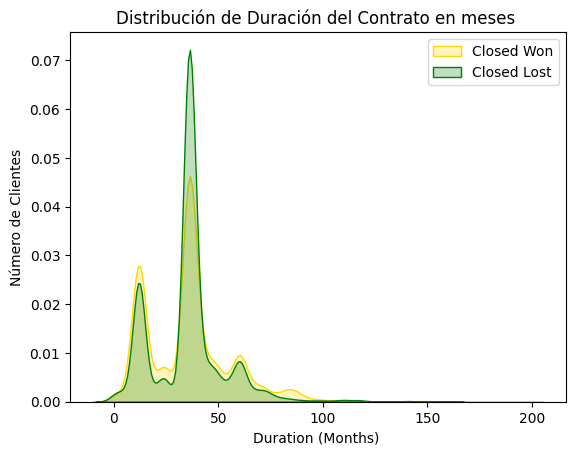

In [46]:
ax = sns.kdeplot(data["Duration (Months)"][(data["Stage"] == '6 - Closed Won') ],
                color="Gold", shade = True);
ax = sns.kdeplot(data["Duration (Months)"][(data["Stage"] == '6 - Closed Lost') ],
                ax =ax, color="Green", shade= True);
ax.legend(["Closed Won","Closed Lost"],loc='upper right');
ax.set_ylabel('Número de Clientes');
ax.set_xlabel('Duration (Months) ');
ax.set_title('Distribución de Duración del Contrato en meses ');

In [47]:
# Filtering data
lost_data = data["Duration (Months)"][data["Stage"] == '6 - Closed Won']
won_data = data["Duration (Months)"][data["Stage"] == '6 - Closed Lost']

# Creating KDE plots
fig = go.Figure()

fig.add_trace(go.Histogram(x=lost_data, histnorm='probability density', name='Closed Lost', marker_color='Gold', opacity=0.5))
fig.add_trace(go.Histogram(x=won_data, histnorm='probability density', name='Closed Won', marker_color='Green', opacity=0.5))

# Update layout
fig.update_layout(barmode='overlay',
                  xaxis=dict(title='Duration (Months)'),
                  yaxis=dict(title='Density'),
                  title='Distribución de la duración del contrato en meses por Estado de la Renovación',
                  legend=dict(x=0.85, y=0.95),
                  )

fig.show()

In [48]:
data.shape

(59392, 33)

In [49]:
# Filtrar los datos
filtered_data = data[data['Stage'].isin(['6 - Closed Won', '6 - Closed Lost'])]

# Crear el gráfico de caja con Plotly
fig = px.box(filtered_data, x='Stage', y='Duration (Months)')

# Actualizar propiedades del eje y
fig.update_yaxes(title_text='Duración del Contrato en meses', row=1, col=1)

# Actualizar propiedades del eje x
fig.update_xaxes(title_text='Etapa de la Renovación', row=1, col=1)

# Actualizar tamaño y título
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='Duración en meses vs Etapa de la Renovación',
)

fig.show()

In [50]:
# Filtrar los datos para incluir solo las etapas relevantes
etapas_relevantes = ['6 - Closed Won', '6 - Closed Lost']
datos_filtrados = data[data['Stage'].isin(etapas_relevantes)]

# Crear el gráfico de caja interactivo con Plotly
fig = px.box(datos_filtrados, x='Stage', y='WEIGHTED RISK PCT',
             title='Distribución del Riesgo por Etapa de la Renovación',
             labels={'Stage': 'Etapa', 'WEIGHTED RISK PCT': 'Porcentaje de Riesgo Ponderado'})
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': etapas_relevantes})
fig.show()

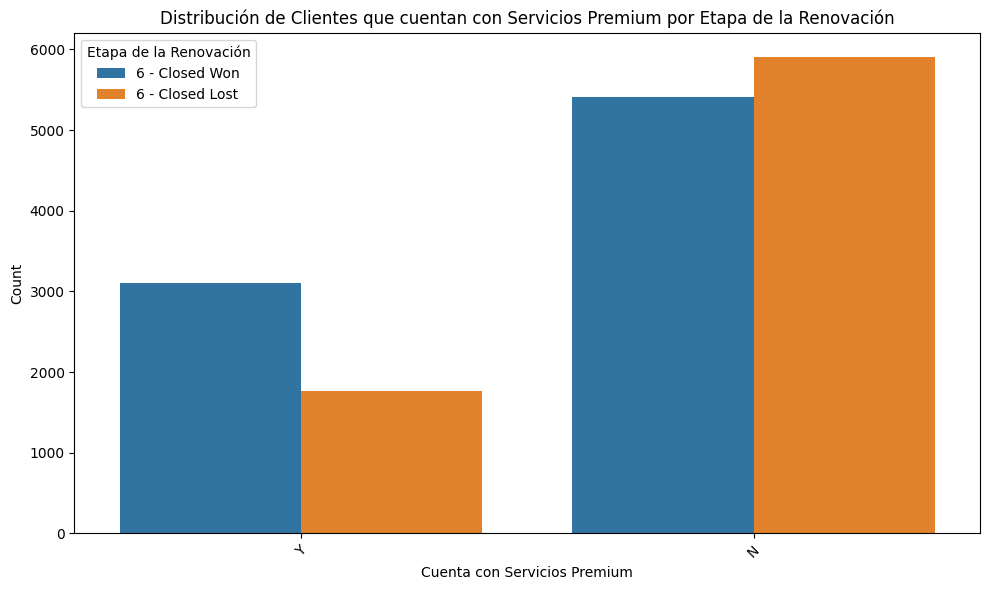

In [51]:
# Filtrar los datos para incluir solo las etapas relevantes
etapas_relevantes = ['6 - Closed Won', '6 - Closed Lost']
datos_filtrados = data[data['Stage'].isin(etapas_relevantes)]

# Graficar la relación entre Stage y Premium Services Flag
plt.figure(figsize=(10, 6))
sns.countplot(data=datos_filtrados, x='Premium Services Flag', hue='Stage')
plt.title('Distribución de Clientes que cuentan con Servicios Premium por Etapa de la Renovación')
plt.xlabel('Cuenta con Servicios Premium')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Etapa de la Renovación')
plt.tight_layout()
plt.show()

In [52]:
# Filtrar los datos para incluir solo las etapas relevantes
etapas_relevantes = ['6 - Closed Won', '6 - Closed Lost']
datos_filtrados = data[data['Stage'].isin(etapas_relevantes)]

# Crear un dataframe para contar
count_df = datos_filtrados.groupby(['Premium Services Flag', 'Stage']).size().reset_index(name='Count')

# Graficar con Plotly
fig = px.bar(count_df, x='Premium Services Flag', y='Count', color='Stage',
             title='Distribución de Clientes que cuentan con Servicios Premium por Etapas de la Renovación',
             labels={'Cuenta con Servicios Premium': 'Premium Services Flag', 'Count': 'Count', 'Stage': 'Stage'},
             barmode='group')

# Rotar las etiquetas del eje x
fig.update_layout(xaxis=dict(tickangle=45))

fig.show()

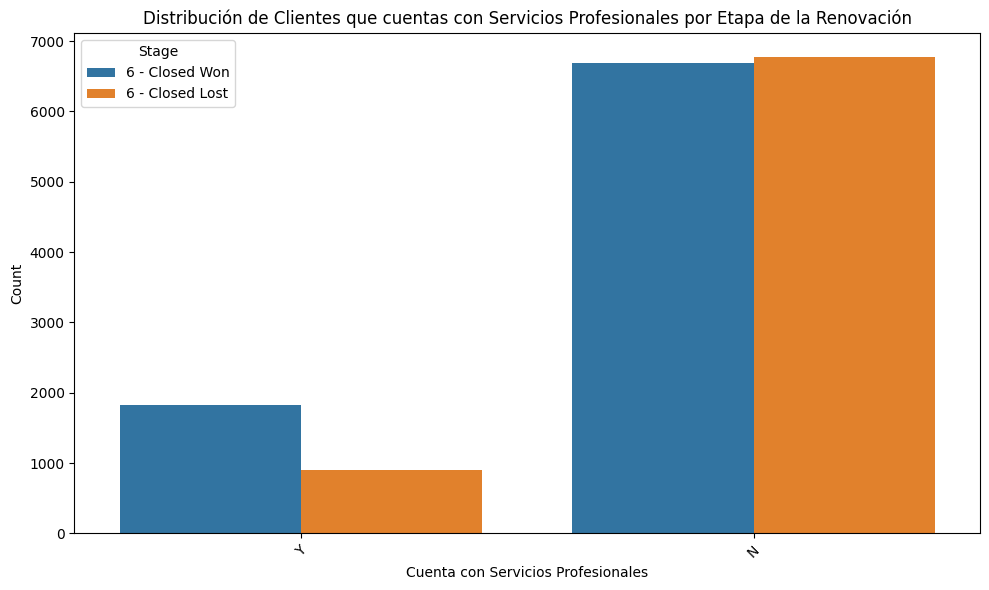

In [53]:
# Filtrar los datos para incluir solo las etapas relevantes
etapas_relevantes = ['6 - Closed Won', '6 - Closed Lost']
datos_filtrados = data[data['Stage'].isin(etapas_relevantes)]

# Graficar la relación entre Stage y Professional Services Flag
plt.figure(figsize=(10, 6))
sns.countplot(data=datos_filtrados, x='Professional Services Flag', hue='Stage')
plt.title('Distribución de Clientes que cuentas con Servicios Profesionales por Etapa de la Renovación')
plt.xlabel('Cuenta con Servicios Profesionales')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()

In [54]:
# Filtrar los datos para incluir solo las etapas relevantes
etapas_relevantes = ['6 - Closed Won', '6 - Closed Lost']
datos_filtrados = data[data['Stage'].isin(etapas_relevantes)]

# Crear un dataframe para contar
count_df = datos_filtrados.groupby(['Professional Services Flag', 'Stage']).size().reset_index(name='Count')

# Graficar con Plotly
fig = px.bar(count_df, x='Professional Services Flag', y='Count', color='Stage',
             title='Distribución de Clientes que cuentan con Servicios Profesionales por Etapa de la Renovación',
             labels={'Professional Services Flag': 'Professional Services Flag', 'Count': 'Count', 'Stage': 'Stage'},
             barmode='group')

# Rotar las etiquetas del eje x
fig.update_layout(xaxis=dict(tickangle=45))

fig.show()

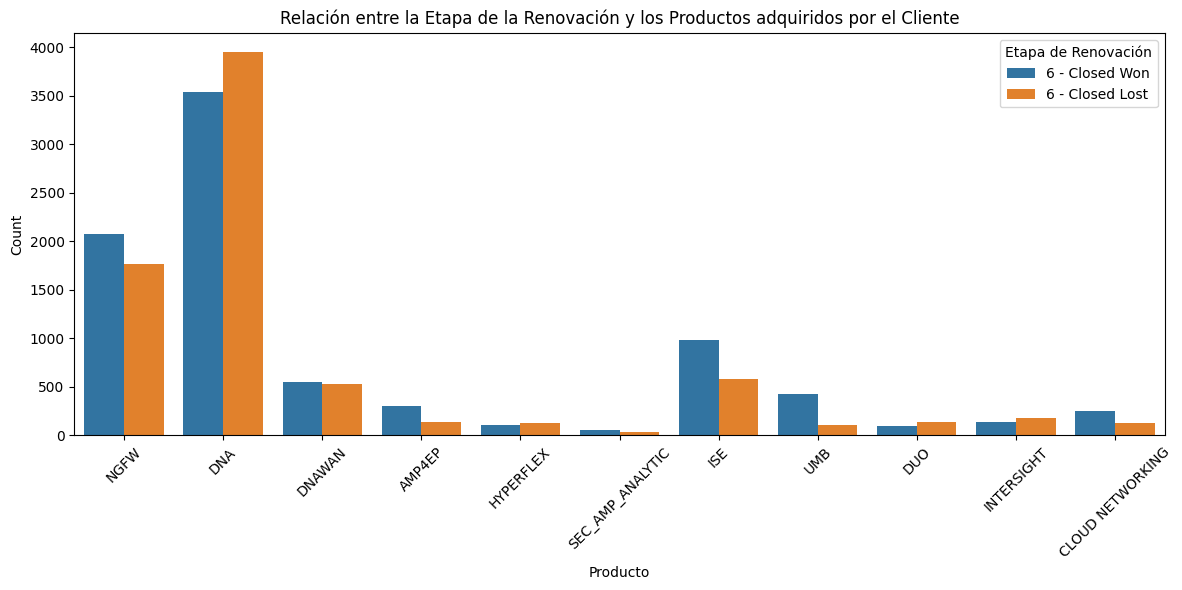

In [55]:
# Filtrar los datos para incluir solo las etapas relevantes
etapas_relevantes = ['6 - Closed Won', '6 - Closed Lost']
datos_filtrados = data[data['Stage'].isin(etapas_relevantes)]

# Crear un gráfico de barras para la relación entre Stage y ATR PRODUCT
plt.figure(figsize=(12, 6))
sns.countplot(x='Product', hue='Stage', data=datos_filtrados)
plt.title('Relación entre la Etapa de la Renovación y los Productos adquiridos por el Cliente')
plt.xlabel('Producto')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Etapa de Renovación')
plt.tight_layout()
plt.show()

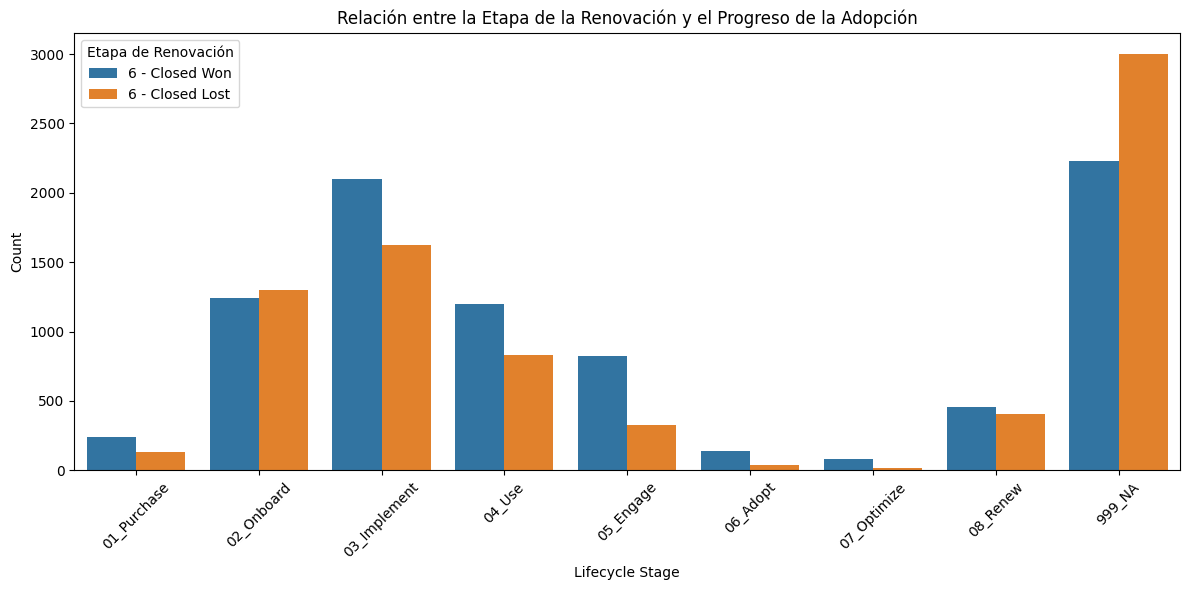

In [56]:
# Crear un gráfico de barras para la relación entre Stage y ATR PRODUCT
plt.figure(figsize=(12, 6))
order = ['01_Purchase', '02_Onboard', '03_Implement', '04_Use', '05_Engage', '06_Adopt', '07_Optimize', '08_Renew', '999_NA']
sns.countplot(x='Lifecycle Stage', hue='Stage', data=datos_filtrados, order=order)
plt.title('Relación entre la Etapa de la Renovación y el Progreso de la Adopción')
plt.xlabel('Lifecycle Stage')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Etapa de Renovación')
plt.tight_layout()
plt.show()

In [57]:
data.shape

(59392, 33)

In [58]:
# Filtrar los datos por etapas relevantes
closed_lost = data[data['Stage'] == '6 - Closed Lost']['ATR']
closed_won = data[data['Stage'] == '6 - Closed Won']['ATR']

# Crear las trazas de densidad para Closed Lost y Closed Won
fig = go.Figure()
fig.add_trace(go.Histogram(x=closed_lost, histnorm='probability density',
                            name='Closed Lost', marker=dict(color='Gold'), opacity=0.5))
fig.add_trace(go.Histogram(x=closed_won, histnorm='probability density',
                            name='Closed Won', marker=dict(color='Green'), opacity=0.5))

# Actualizar el diseño del gráfico
fig.update_layout(title='ATR por Etapa de la Renovación',
                  xaxis_title='ATR',
                  yaxis_title='Densidad',
                  barmode='overlay')

# Mostrar el gráfico
fig.show()

<ipython-input-59-64c276f27e42>:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-59-64c276f27e42>:10: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




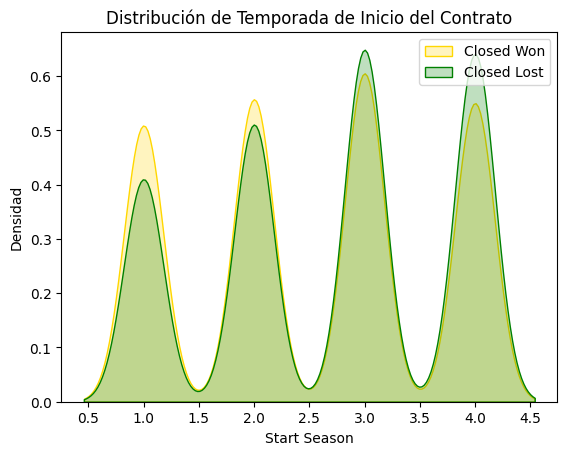

In [59]:
# Mapear las categorías de Start Season a números
season_mapping = {'Spring': 1, 'Summer': 2, 'Fall': 3, 'Winter': 4}
data['Start Season Numerical'] = data['Start Season'].map(season_mapping)

# Trama de densidad de kernel para "Closed Won"
ax = sns.kdeplot(data["Start Season Numerical"][data["Stage"] == '6 - Closed Won'],
                 color="Gold", shade=True)

# Trama de densidad de kernel para "Closed Lost"
ax = sns.kdeplot(data["Start Season Numerical"][data["Stage"] == '6 - Closed Lost'],
                 ax=ax, color="Green", shade=True)

# Agregar leyendas y etiquetas
ax.legend(["Closed Won", "Closed Lost"], loc='upper right')
ax.set_ylabel('Densidad')
ax.set_xlabel('Start Season')
ax.set_title('Distribución de Temporada de Inicio del Contrato')

# Mostrar el gráfico
plt.show()

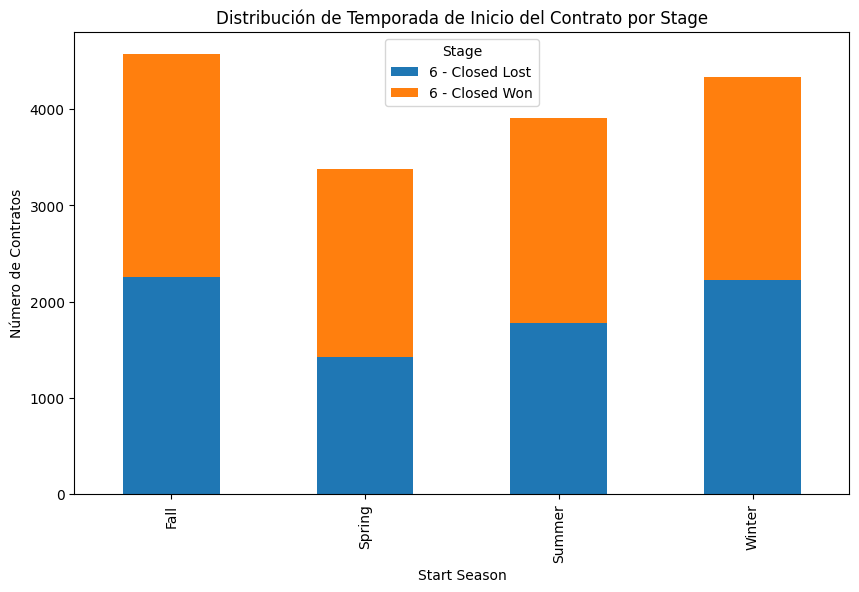

In [60]:
# Filtrar el DataFrame para incluir solo las dos etapas específicas
filtered_data = data[data['Stage'].isin(['6 - Closed Won', '6 - Closed Lost'])]

# Contar el número de contratos por temporada y etapa
season_stage_counts = filtered_data.groupby(['Start Season', 'Stage']).size().unstack()

# Crear el gráfico de barras apiladas
season_stage_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Añadir etiquetas y título
plt.xlabel('Start Season')
plt.ylabel('Número de Contratos')
plt.title('Distribución de Temporada de Inicio del Contrato por Stage')

# Mostrar el gráfico
plt.legend(title='Stage')
plt.show()

In [61]:
data.shape

(59392, 34)

In [62]:
variables_numericas =  ['ATR',  'WEIGHTED RISK PCT',
'Duration (Months)','Antigüedad del Cliente (días)', 'Dias_Entre_Contratos_Pasado_Y_Actual','media_movil_duracion','media_movil_atr', 'Start Month', 'End Month', 'Start Day','End Day', 'Start Day of Week', 'End Day of Week','Deal_ID_Count']

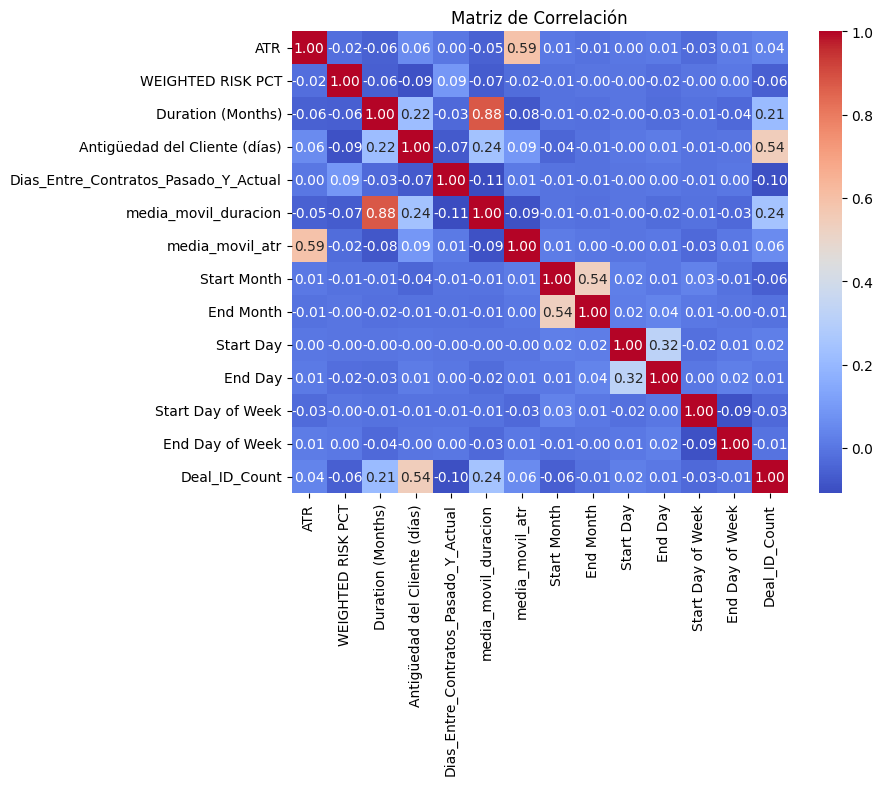

In [63]:
# Calcular la matriz de correlación
correlation_matrix = data[variables_numericas].corr()

# Crear la matriz de correlación con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [64]:
# Columnas categóricas a convertir en dummies
categorical_cols = ['Product', 'Professional Services Flag', 'Premium Services Flag', 'CSE Flag', 'Lifecycle Stage', 'ATR Band','Is Digital Enrolled', 'De-Risk Flag', 'Duration Band', 'INDUSTRY', 'Start Season', 'End Season']

# Obtener variables dummy para las columnas categóricas
data_dummies = pd.get_dummies(data[categorical_cols], prefix=categorical_cols)

# Concatenar las variables dummy con el DataFrame original
data = pd.concat([data, data_dummies], axis=1)

# Eliminar las columnas originales categóricas si ya no son necesarias
data.drop(categorical_cols, axis=1, inplace=True)

In [65]:
data.shape

(59392, 88)

In [66]:
data.to_csv('/content/drive/MyDrive/Hackathon CX 2024/oportunidades_renovacion_preprocesadas.csv', index=False)


In [67]:
data.head()

GLOBAL_ULTIMATE_ID     ATR  WEIGHTED RISK PCT  Duration (Months)  \
40835                7000 2457.58              79.17              12.00   
13809                7000 7169.93              20.00              12.00   
56368                7000 7150.29              81.40              24.00   
8380                 7000 1738.16              20.00              12.00   
25524                9000  562.78              15.31              60.00   

       Antigüedad del Cliente (días)  Dias_Entre_Contratos_Pasado_Y_Actual  \
40835                            978                                     0   
13809                            978                                   348   
56368                            978                                     0   
8380                             978                                   117   
25524                           2194                                     0   

       media_movil_duracion  media_movil_atr Contract_Start_Date  \
40835                 12.00          2457.58          2023-07-12   
13809                 12.00          4813.76          2022-07-29   
56368                 16.00          5592.60          2022-07-29   
8380                  15.00          4628.99          2022-04-03   
25524                 60.00           562.78          2020-07-10   

      Term_End_Date  Start Month  End Month  Start Day  End Day  \
40835    2024-07-11            7          7         12       11   
13809    2023-07-28            7          7         29       28   
56368    2024-07-28            7          7         29       28   
8380     2023-04-02            4          4          3        2   
25524    2025-07-09            7          7         10        9   

       Start Day of Week  End Day of Week  Deal_ID_Count            Stage  \
40835                  2                3              1     1 - Prospect   
13809                  4                4              2   6 - Closed Won   
56368                  4                6              3     1 - Prospect   
8380                   6                6              4  6 - Closed Lost   
25524                  4                2              1     1 - Prospect   

       SENTIMENT_CSAT  TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
40835               1              0                1                       2   
13809               0              1                1                       2   
56368               0              1                0                       2   
8380                1              0                0                       1   
25524               1              1                1                       2   

       Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  Product_DNAWAN  \
40835           False                     False        False           False   
13809           False                     False        False           False   
56368           False                     False        False           False   
8380            False                     False        False           False   
25524           False                     False        False           False   

       Product_DUO  Product_HYPERFLEX  Product_INTERSIGHT  Product_ISE  \
40835        False              False               False        False   
13809        False              False               False        False   
56368        False              False               False        False   
8380         False              False               False        False   
25524        False              False               False        False   

       Product_NGFW  Product_SEC_AMP_ANALYTIC  Product_UMB  \
40835          True                     False        False   
13809          True                     False        False   
56368          True                     False        False   
8380           True                     False        False   
25524          True                     False        False   

       Professional Servic

In [68]:
data_entrenamiento = data[~data['Stage'].isin(['0 - Target','6 - Closed Cancelled', '2 - Qualify', '3 - Proposal', '5 - Negotiate', '4 - Selection', '1 - Prospect'])]

In [69]:
data_entrenamiento.set_index("GLOBAL_ULTIMATE_ID", inplace=True)

In [70]:
data_entrenamiento.shape

(16196, 87)

In [71]:
# Seleccionar las características y la variable objetivo
columnas_a_eliminar = ['Stage', 'Contract_Start_Date', 'Term_End_Date']
X = data_entrenamiento.drop(columnas_a_eliminar, axis=1)
y = data_entrenamiento['Stage']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [72]:
X.shape

(16196, 84)

In [73]:
X.head()

ATR  WEIGHTED RISK PCT  Duration (Months)  \
GLOBAL_ULTIMATE_ID                                                 
7000               7169.93              20.00              12.00   
7000               1738.16              20.00              12.00   
9000                469.00              85.00              44.30   
9000                  0.00               0.00              49.90   
9000                879.67              85.00              49.90   

                    Antigüedad del Cliente (días)  \
GLOBAL_ULTIMATE_ID                                  
7000                                          978   
7000                                          978   
9000                                         2194   
9000                                         2194   
9000                                         2194   

                    Dias_Entre_Contratos_Pasado_Y_Actual  \
GLOBAL_ULTIMATE_ID                                         
7000                                                 348   
7000                                                 117   
9000                                                 223   
9000                                                   0   
9000                                                   0   

                    media_movil_duracion  media_movil_atr  Start Month  \
GLOBAL_ULTIMATE_ID                                                       
7000                               12.00          4813.76            7   
7000                               15.00          4628.99            4   
9000                               47.26           701.62           12   
9000                               45.24           589.06           12   
9000                               43.22           665.83           12   

                    End Month  Start Day  End Day  Start Day of Week  \
GLOBAL_ULTIMATE_ID                                                     
7000                        7         29       28                  4   
7000                        4          3        2                  6   
9000                        8          4       13                  1   
9000                        1          4       31                  1   
9000                        1          4       31                  1   

                    End Day of Week  Deal_ID_Count  SENTIMENT_CSAT  \
GLOBAL_ULTIMATE_ID                                                   
7000                              4              2               0   
7000                              6              4               1   
9000                              5              5               0   
9000                              1              6               0   
9000                              1              7               1   

                    TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
GLOBAL_ULTIMATE_ID                                                           
7000                            1                1                       2   
7000                            0                0                       1   
9000                            1                0                       4   
9000                            1                1                       4   
9000                            1                0                       4   

                    Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  \
GLOBAL_ULTIMATE_ID                                                          
7000                         False                     False        False   
7000                         False                     False        False   
9000                         False                     False         True   
9000                         False                     False         True   
9000                         False                     False         True   

                    Product_DNAWAN  Product_DUO  Product_HYPERFLEX  \
GLOBAL_ULTIMATE_ID                                                   
7000       

In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16196 entries, 7000 to 395033075
Data columns (total 84 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ATR                                    16196 non-null  float64
 1   WEIGHTED RISK PCT                      16196 non-null  float64
 2   Duration (Months)                      16196 non-null  float64
 3   Antigüedad del Cliente (días)          16196 non-null  int64  
 4   Dias_Entre_Contratos_Pasado_Y_Actual   16196 non-null  int64  
 5   media_movil_duracion                   16196 non-null  float64
 6   media_movil_atr                        16196 non-null  float64
 7   Start Month                            16196 non-null  int32  
 8   End Month                              16196 non-null  int32  
 9   Start Day                              16196 non-null  int32  
 10  End Day                                16196 non-null  int32  
 11  

In [75]:
X.to_csv('/content/drive/MyDrive/Hackathon CX 2024/X2.csv', index=True)


## Creación y Entrenamiento del modelo de clasificación: RandomForest

In [76]:
# Entrenar el modelo de Random Forest
model = RandomForestClassifier(n_estimators=150,     # Número de árboles en el bosque
                               max_depth=None,       # Profundidad máxima de cada árbol
                               min_samples_split=2,  # Número mínimo de muestras requeridas para dividir un nodo interno
                               min_samples_leaf=1,   # Número mínimo de muestras requeridas para ser un nodo hoja
                               random_state=42,      # Semilla para reproducibilidad
                               class_weight= 'balanced')


model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.8403292181069959


In [77]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

6 - Closed Lost       0.84      0.83      0.83      1160
 6 - Closed Won       0.84      0.85      0.85      1270

       accuracy                           0.84      2430
      macro avg       0.84      0.84      0.84      2430
   weighted avg       0.84      0.84      0.84      2430



In [78]:
#dataframe con las predicciones

y_pred_df = pd.DataFrame(y_pred, columns=['Predicted Stage'])
y_pred_df.head()

Predicted Stage
0   6 - Closed Won
1  6 - Closed Lost
2   6 - Closed Won
3  6 - Closed Lost
4  6 - Closed Lost

In [79]:
y_pred_df.index = X_test.index

#Juntar X_test con predicciones en un solo dataframe

merged_df = pd.concat([X_test, y_pred_df], axis=1)
merged_df.head()

ATR  WEIGHTED RISK PCT  Duration (Months)  \
GLOBAL_ULTIMATE_ID                                                 
323596969          1579.33              72.23              13.80   
91767                 0.00               1.13              37.00   
2689130               0.00               0.00              14.20   
314393554          1548.60              85.00              36.00   
6829599            3248.29              52.92              36.20   

                    Antigüedad del Cliente (días)  \
GLOBAL_ULTIMATE_ID                                  
323596969                                    1772   
91767                                        2642   
2689130                                      4079   
314393554                                    1867   
6829599                                      2328   

                    Dias_Entre_Contratos_Pasado_Y_Actual  \
GLOBAL_ULTIMATE_ID                                         
323596969                                              0   
91767                                                  8   
2689130                                               87   
314393554                                             31   
6829599                                                0   

                    media_movil_duracion  media_movil_atr  Start Month  \
GLOBAL_ULTIMATE_ID                                                       
323596969                          13.20          1115.06            1   
91767                              36.20          1342.79           12   
2689130                            14.84         68128.73            4   
314393554                          36.18           568.72           10   
6829599                            36.08          2178.55            1   

                    End Month  Start Day  End Day  Start Day of Week  \
GLOBAL_ULTIMATE_ID                                                     
323596969                   3         30       25                  3   
91767                      12          2       31                  3   
2689130                     6         13       19                  1   
314393554                  10         27       26                  6   
6829599                     1          5       11                  1   

                    End Day of Week  Deal_ID_Count  SENTIMENT_CSAT  \
GLOBAL_ULTIMATE_ID                                                   
323596969                         3              3               1   
91767                             1             64               1   
2689130                           6             99               0   
314393554                         2             47               1   
6829599                           3             28               1   

                    TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
GLOBAL_ULTIMATE_ID                                                           
323596969                       1                1                       4   
91767                           0                0                       4   
2689130                         1                0                       1   
314393554                       0                1                       3   
6829599                         1                1                       4   

                    Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  \
GLOBAL_ULTIMATE_ID                                                          
323596969                    False                     False        False   
91767                        False                     False         True   
2689130                      False                     False         True   
314393554                    False                     False        False   
6829599                      False                     False         True   

                    Product_DNAWAN  Product_DUO  Product_HYPERFLEX  \
GLOBAL_ULTIMATE_ID                                                   
323596969  

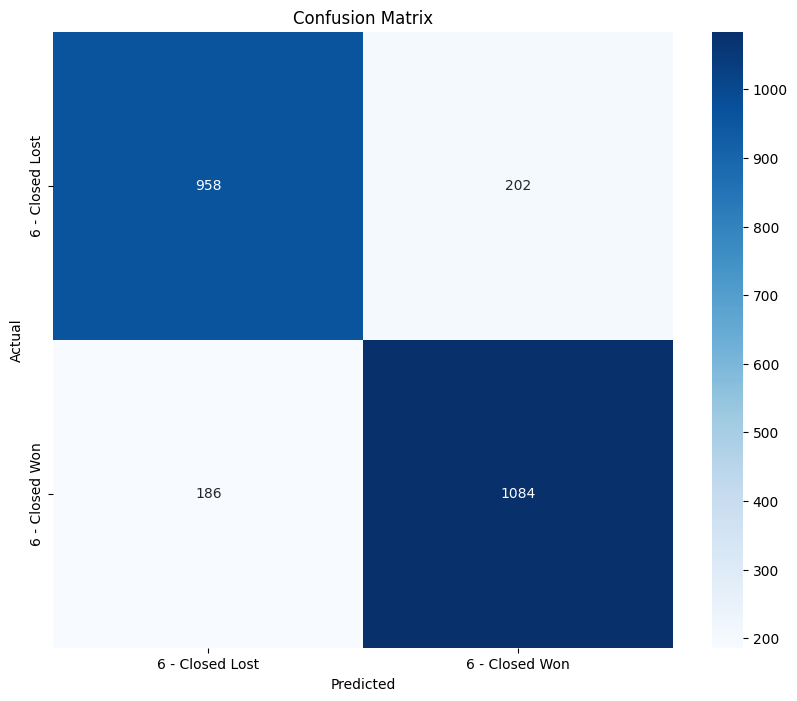

In [80]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un DataFrame de la matriz de confusión
labels = sorted(y_test.unique())
confusion_df = pd.DataFrame(cm, index=labels, columns=labels)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Interpretabilidad del Modelo

In [81]:
# Obtener los nombres de las características
feature_names = X_train.columns.tolist()

# Convertir X_train a DataFrame de pandas si no lo es ya
X_train = pd.DataFrame(X_train, columns=feature_names)

# Obtener las etiquetas únicas de las clases
unique_classes = sorted(set(y_train))

# Mapear los números de clase a nombres de clase
class_names = [f'Class {c}' for c in unique_classes]
X_train.reset_index(drop=True, inplace=True)
# Crear una instancia del explainer de LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=feature_names, class_names=class_names, discretize_continuous=True)

# Seleccionar una observación para explicar (puedes cambiar el índice)
observation = X_test.iloc[20]
# Explicar la predicción utilizando LIME
exp = explainer.explain_instance(observation, model.predict_proba)

# Mostrar la explicación
exp.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid fe

## Cálculo de Feature Importance

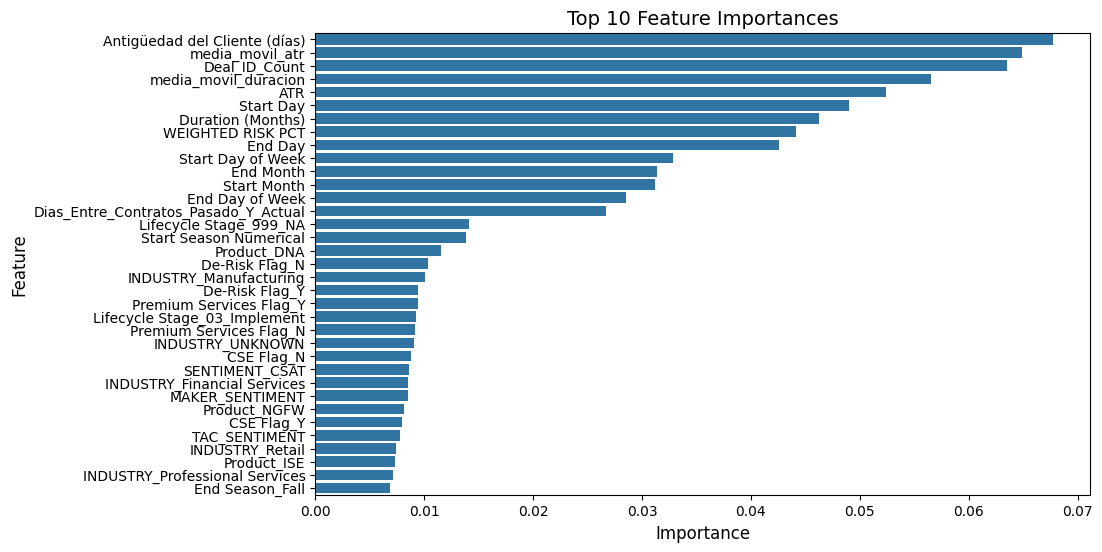

In [82]:
# Feature importance de primeras 15 columnas
importances = model.feature_importances_

# Sort importances and select top 10
sorted_indices = np.argsort(importances)[::-1][:35]
sorted_features = X_train.columns[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_indices], y=sorted_features)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 10 Feature Importances', fontsize=14)
plt.show()

### Predicciones en Data nueva

In [83]:
data_validacion = data[data['Stage'].isin(['2 - Qualify', '3 - Proposal', '5 - Negotiate', '4 - Selection', '1 - Prospect'])]

In [84]:
data_validacion.head()

GLOBAL_ULTIMATE_ID     ATR  WEIGHTED RISK PCT  Duration (Months)  \
40835                7000 2457.58              79.17              12.00   
56368                7000 7150.29              81.40              24.00   
25524                9000  562.78              15.31              60.00   
21568                9000 1376.17              20.00              36.00   
27681               10043 1164.60              92.41              36.00   

       Antigüedad del Cliente (días)  Dias_Entre_Contratos_Pasado_Y_Actual  \
40835                            978                                     0   
56368                            978                                     0   
25524                           2194                                     0   
21568                           2194                                   155   
27681                           2474                                     6   

       media_movil_duracion  media_movil_atr Contract_Start_Date  \
40835                 12.00          2457.58          2023-07-12   
56368                 16.00          5592.60          2022-07-29   
25524                 60.00           562.78          2020-07-10   
21568                 52.00           811.58          2020-01-07   
27681                 36.00           791.12          2022-11-25   

      Term_End_Date  Start Month  End Month  Start Day  End Day  \
40835    2024-07-11            7          7         12       11   
56368    2024-07-28            7          7         29       28   
25524    2025-07-09            7          7         10        9   
21568    2023-01-06            1          1          7        6   
27681    2025-11-24           11         11         25       24   

       Start Day of Week  End Day of Week  Deal_ID_Count         Stage  \
40835                  2                3              1  1 - Prospect   
56368                  4                6              3  1 - Prospect   
25524                  4                2              1  1 - Prospect   
21568                  1                4              3  1 - Prospect   
27681                  4                0              2  3 - Proposal   

       SENTIMENT_CSAT  TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
40835               1              0                1                       2   
56368               0              1                0                       2   
25524               1              1                1                       2   
21568               1              1                0                       4   
27681               0              1                1                       3   

       Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  Product_DNAWAN  \
40835           False                     False        False           False   
56368           False                     False        False           False   
25524           False                     False        False           False   
21568           False                     False        False           False   
27681           False                     False         True           False   

       Product_DUO  Product_HYPERFLEX  Product_INTERSIGHT  Product_ISE  \
40835        False              False               False        False   
56368        False              False               False        False   
25524        False              False               False        False   
21568        False              False               False        False   
27681        False              False               False        False   

       Product_NGFW  Product_SEC_AMP_ANALYTIC  Product_UMB  \
40835          True                     False        False   
56368          True                     False        False   
25524          True                     False        False   
21568          True                     False        False   
27681         False                     False        False   

       Professional Services Flag_N  Profess

In [85]:
data_validacion.set_index("GLOBAL_ULTIMATE_ID", inplace=True)

In [86]:
# Seleccionar las características y la variable objetivo
columnas_a_eliminar = ['Stage', 'Contract_Start_Date', 'Term_End_Date']
X = data_validacion.drop(columnas_a_eliminar, axis=1)

In [87]:
# Predecir en el conjunto de prueba
y_valid = model.predict(X)

In [88]:
#dataframe con las predicciones
y_valid_df = pd.DataFrame(y_valid, columns=['Predicted Stage'])
y_valid_df.head()

Predicted Stage
0   6 - Closed Won
1   6 - Closed Won
2   6 - Closed Won
3   6 - Closed Won
4  6 - Closed Lost

In [89]:
#Juntar X_test con predicciones en un solo dataframe
y_valid_df.index = X.index
merged_df_validaciones = pd.concat([X, y_valid_df], axis=1)
merged_df_validaciones.head()

ATR  WEIGHTED RISK PCT  Duration (Months)  \
GLOBAL_ULTIMATE_ID                                                 
7000               2457.58              79.17              12.00   
7000               7150.29              81.40              24.00   
9000                562.78              15.31              60.00   
9000               1376.17              20.00              36.00   
10043              1164.60              92.41              36.00   

                    Antigüedad del Cliente (días)  \
GLOBAL_ULTIMATE_ID                                  
7000                                          978   
7000                                          978   
9000                                         2194   
9000                                         2194   
10043                                        2474   

                    Dias_Entre_Contratos_Pasado_Y_Actual  \
GLOBAL_ULTIMATE_ID                                         
7000                                                   0   
7000                                                   0   
9000                                                   0   
9000                                                 155   
10043                                                  6   

                    media_movil_duracion  media_movil_atr  Start Month  \
GLOBAL_ULTIMATE_ID                                                       
7000                               12.00          2457.58            7   
7000                               16.00          5592.60            7   
9000                               60.00           562.78            7   
9000                               52.00           811.58            1   
10043                              36.00           791.12           11   

                    End Month  Start Day  End Day  Start Day of Week  \
GLOBAL_ULTIMATE_ID                                                     
7000                        7         12       11                  2   
7000                        7         29       28                  4   
9000                        7         10        9                  4   
9000                        1          7        6                  1   
10043                      11         25       24                  4   

                    End Day of Week  Deal_ID_Count  SENTIMENT_CSAT  \
GLOBAL_ULTIMATE_ID                                                   
7000                              3              1               1   
7000                              6              3               0   
9000                              2              1               1   
9000                              4              3               1   
10043                             0              2               0   

                    TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
GLOBAL_ULTIMATE_ID                                                           
7000                            0                1                       2   
7000                            1                0                       2   
9000                            1                1                       2   
9000                            1                0                       4   
10043                           1                1                       3   

                    Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  \
GLOBAL_ULTIMATE_ID                                                          
7000                         False                     False        False   
7000                         False                     False        False   
9000                         False                     False        False   
9000                         False                     False        False   
10043                        False                     False         True   

                    Product_DNAWAN  Product_DUO  Product_HYPERFLEX  \
GLOBAL_ULTIMATE_ID                                                   
7000       

In [90]:
merged_df_validaciones[merged_df_validaciones["Predicted Stage"] == "6 - Closed Lost"].head()

ATR  WEIGHTED RISK PCT  Duration (Months)  \
GLOBAL_ULTIMATE_ID                                                 
10043              1164.60              92.41              36.00   
10043              1363.70              66.94              36.00   
10173               910.38              48.86              36.00   
10327                 0.00              96.53              36.00   
10327                 0.00              96.53              36.00   

                    Antigüedad del Cliente (días)  \
GLOBAL_ULTIMATE_ID                                  
10043                                        2474   
10043                                        2474   
10173                                        1503   
10327                                        1975   
10327                                        1975   

                    Dias_Entre_Contratos_Pasado_Y_Actual  \
GLOBAL_ULTIMATE_ID                                         
10043                                                  6   
10043                                                183   
10173                                                  0   
10327                                                  0   
10327                                                  0   

                    media_movil_duracion  media_movil_atr  Start Month  \
GLOBAL_ULTIMATE_ID                                                       
10043                              36.00           791.12           11   
10043                              42.80           439.40            8   
10173                              36.00           455.19            4   
10327                              36.00             0.00            8   
10327                              36.00             0.00            8   

                    End Month  Start Day  End Day  Start Day of Week  \
GLOBAL_ULTIMATE_ID                                                     
10043                      11         25       24                  4   
10043                       8         25       24                  2   
10173                       4         26       25                  2   
10327                       8         21       20                  0   
10327                       8         21       20                  0   

                    End Day of Week  Deal_ID_Count  SENTIMENT_CSAT  \
GLOBAL_ULTIMATE_ID                                                   
10043                             0              2               0   
10043                             5             10               0   
10173                             5              2               0   
10327                             3              1               0   
10327                             3              2               1   

                    TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
GLOBAL_ULTIMATE_ID                                                           
10043                           1                1                       3   
10043                           1                0                       2   
10173                           1                0                       1   
10327                           1                1                       2   
10327                           1                1                       2   

                    Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  \
GLOBAL_ULTIMATE_ID                                                          
10043                        False                     False         True   
10043                        False                     False         True   
10173                        False                     False         True   
10327                        False                     False         True   
10327                        False                     False        False   

                    Product_DNAWAN  Product_DUO  Product_HYPERFLEX  \
GLOBAL_ULTIMATE_ID                                                   
10043      

In [91]:
merged_df_validaciones[merged_df_validaciones["Predicted Stage"] == "6 - Closed Won"].head()

ATR  WEIGHTED RISK PCT  Duration (Months)  \
GLOBAL_ULTIMATE_ID                                                 
7000               2457.58              79.17              12.00   
7000               7150.29              81.40              24.00   
9000                562.78              15.31              60.00   
9000               1376.17              20.00              36.00   
10069              5417.40              17.05              36.00   

                    Antigüedad del Cliente (días)  \
GLOBAL_ULTIMATE_ID                                  
7000                                          978   
7000                                          978   
9000                                         2194   
9000                                         2194   
10069                                         501   

                    Dias_Entre_Contratos_Pasado_Y_Actual  \
GLOBAL_ULTIMATE_ID                                         
7000                                                   0   
7000                                                   0   
9000                                                   0   
9000                                                 155   
10069                                                  0   

                    media_movil_duracion  media_movil_atr  Start Month  \
GLOBAL_ULTIMATE_ID                                                       
7000                               12.00          2457.58            7   
7000                               16.00          5592.60            7   
9000                               60.00           562.78            7   
9000                               52.00           811.58            1   
10069                              36.00          5417.40            7   

                    End Month  Start Day  End Day  Start Day of Week  \
GLOBAL_ULTIMATE_ID                                                     
7000                        7         12       11                  2   
7000                        7         29       28                  4   
9000                        7         10        9                  4   
9000                        1          7        6                  1   
10069                       7         24       23                  0   

                    End Day of Week  Deal_ID_Count  SENTIMENT_CSAT  \
GLOBAL_ULTIMATE_ID                                                   
7000                              3              1               1   
7000                              6              3               0   
9000                              2              1               1   
9000                              4              3               1   
10069                             3              1               1   

                    TAC_SENTIMENT  MAKER_SENTIMENT  Start Season Numerical  \
GLOBAL_ULTIMATE_ID                                                           
7000                            0                1                       2   
7000                            1                0                       2   
9000                            1                1                       2   
9000                            1                0                       4   
10069                           0                0                       2   

                    Product_AMP4EP  Product_CLOUD NETWORKING  Product_DNA  \
GLOBAL_ULTIMATE_ID                                                          
7000                         False                     False        False   
7000                         False                     False        False   
9000                         False                     False        False   
9000                         False                     False        False   
10069                        False                     False        False   

                    Product_DNAWAN  Product_DUO  Product_HYPERFLEX  \
GLOBAL_ULTIMATE_ID                                                   
7000       

In [92]:
import joblib

# Ruta en Google Drive
model_path = '/content/drive/MyDrive/Hackathon CX 2024/model.pkl'

# Guardar modelo entrenado
joblib.dump(model, model_path)
print(f'Modelo guardado en: {model_path}')


Modelo guardado en: /content/drive/MyDrive/Hackathon CX 2024/model.pkl


In [93]:
print(f"Tipo de objeto del modelo cargado: {type(model)}")


Tipo de objeto del modelo cargado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [94]:
!python -c "import sklearn; print(sklearn.__version__)"

1.5.2
